# [Neural Style Transfer](https://bkshin.tistory.com/entry/%EC%BB%B4%ED%93%A8%ED%84%B0-%EB%B9%84%EC%A0%84-14-%EC%8A%A4%ED%83%80%EC%9D%BC-%EC%A0%84%EC%9D%B4Style-Transfer)
- 스타일 전이란 콘텐츠 이미지(content image)에 스타일 이미지(style image)의 화풍을 적용해 새로운 이미지를 생성하는 기법을 말합니다.
- 아래 예시는 원본 이미지인 A(이를 콘텐츠 이미지라고 부름)를 기준으로 각 화풍(이를 스타일 이미지라고 부름)에 맞게 스타일을 적용해 새로운 이미지를 만든 예시들입니다.

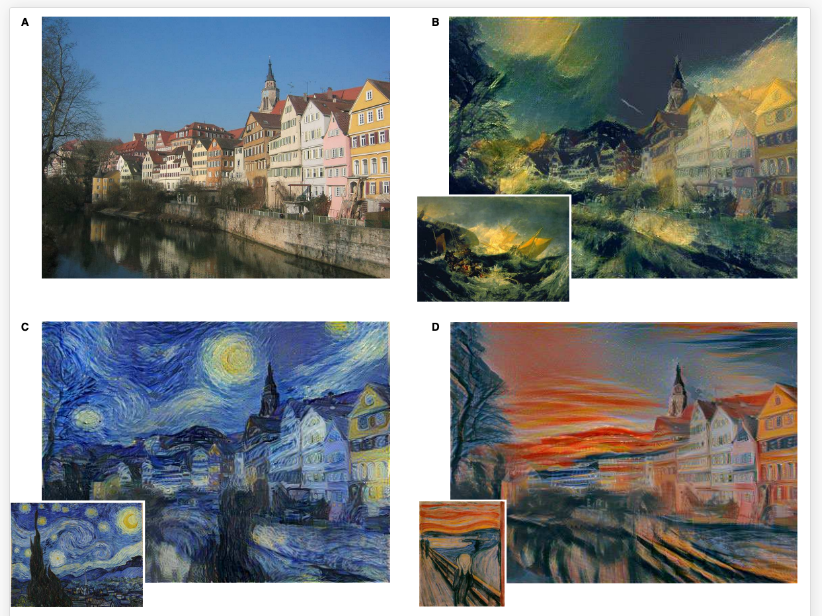

## Style Transfer 이론
- 먼저, 스타일 전이를 적용하려면 사전 훈련된(pre-trained) CNN 모델을 사용해야 합니다.
- Style Transfer 논문에서는 VGG19 네트워크를 사용했습니다. 스타일 전이 훈련 시에는 VGG19 네트워크의 가중치는 고정한 뒤 이미지의 픽셀을 직접 변경하면서 훈련합니다.
- 모델 훈련이라고 하면 일반적으로는 가중치를 업데이트하는 걸 말합니다.
- 하지만 스타일 전이에서는 가중치는 고정한 채, 이미지의 픽셀을 변경하면서 업데이트를 합니다.

다시 말해 아래와 같은 방식으로 훈련이 됩니다.

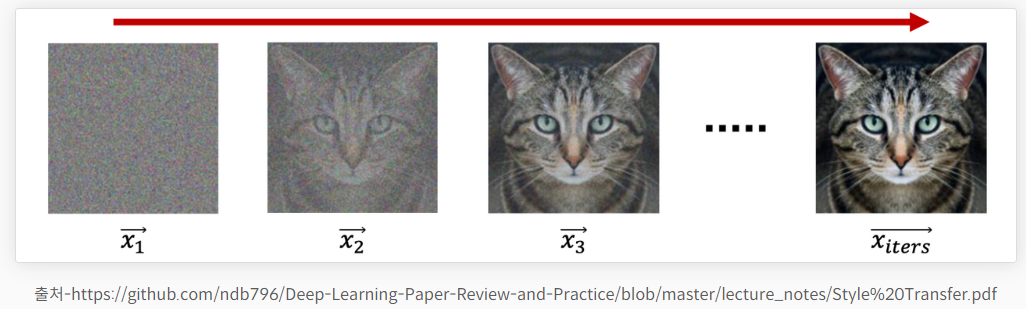

## 손실함수
- 랜덤 노이즈 이미지(x)는 콘텐츠 이미지(p)와 스타일 이미지(a)를 결합해 새로운 이미지(result x)를 생성합니다.
- 우선 이미지는 행과 열로 구성돼 있습니다. 그렇지만 계산을 쉽게 하기 위해 하나의 이미지를 하나의 벡터로 표현합니다(p, a, x 등). 그냥 행, 열을 일렬로 쭉 나열해 벡터로 표현했다고 보면 됩니다.
- 노이즈 이미지에서 시작해 콘텐츠 정보와 스타일 정보를 모두 가져오면서 훈련을 합니다.
- 여기서 콘텐츠 손실(L_content)이 줄어든다는 건 콘텐츠의 이미지를 잘 가져왔다는 뜻이고, 스타일 손실(L_sytle)이 줄어든다는 건 스타일의 화풍을 잘 가져왔다는 말입니다.
- α는 콘텐츠 손실의 가중치, β는 스타일 손실의 가중치입니다. 각 가중치가 클수록 해당 손실값을 더 중요하게 여깁니다.
- 콘텐츠 손실의 가중치(α)와 스타일 손실의 가중치(β) 비율에 따라 생성되는 이미지가 다르다는 말입니다. 다시 말해 α가 클수록 콘텐츠의 이미지를 잘 복원합니다.

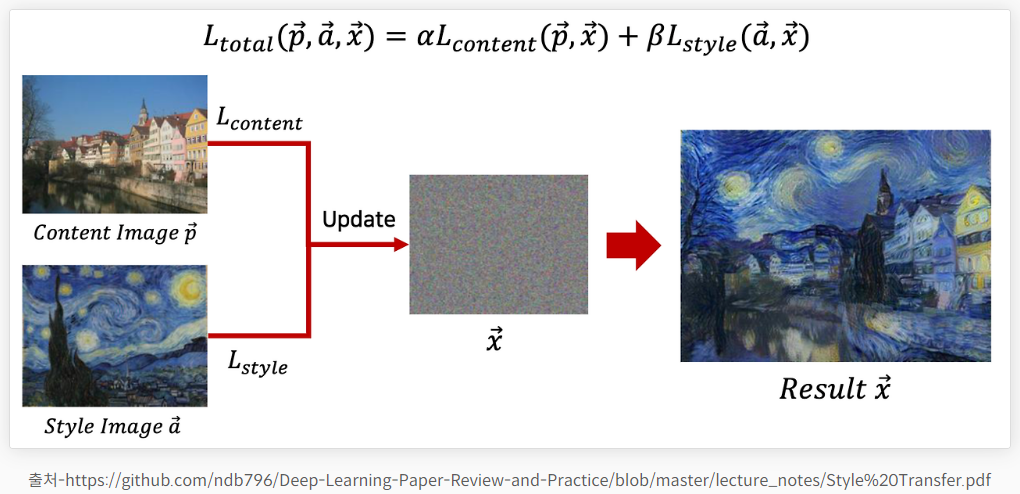

- 왼쪽 상단 그림의 가중치 비율(α / β)은 10^-4입니다. 스타일 손실 가중치(β)가 콘텐츠 손실 가중치(α)보다 10,000배 크다는 뜻입니다.
- 스타일 손실의 가중치가 크면 클수록 원본 콘텐츠를 확인하기 어렵습니다.

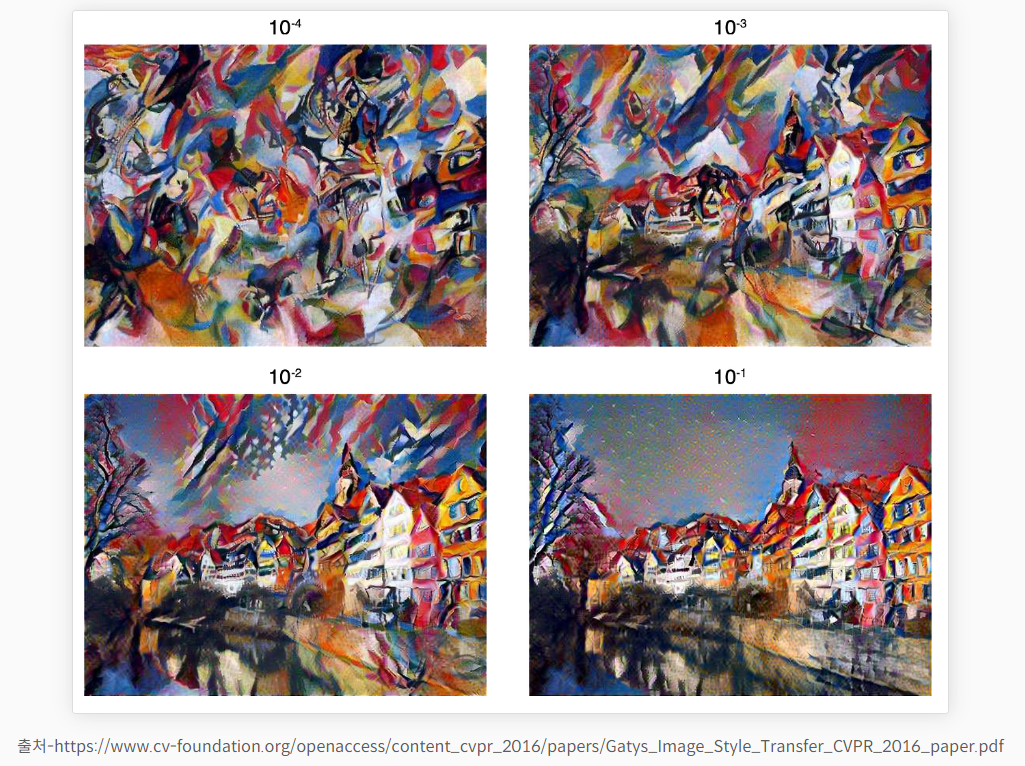

## 이미지 재건(Image Reconstruction)
- 먼저 위쪽의 스타일 재건을 보시죠. a부터 e이미지까지 생성된 스타일 이미지가 다르죠? 어떤 레이어를 바탕으로 스타일 손실을 잡았는지에 따라 최종 생성된 스타일 이미지가 다릅니다.
- 레이어를 많이 포함할수록 스타일(화풍)을 더 잘 재건합니다.
- 레이어가 깊어질수록 구체적인 픽셀 정보가 없어지네요. 뒤쪽 레이어로 잡을수록 원본 이미지의 콘텐츠가 없어진다는 뜻입니다.

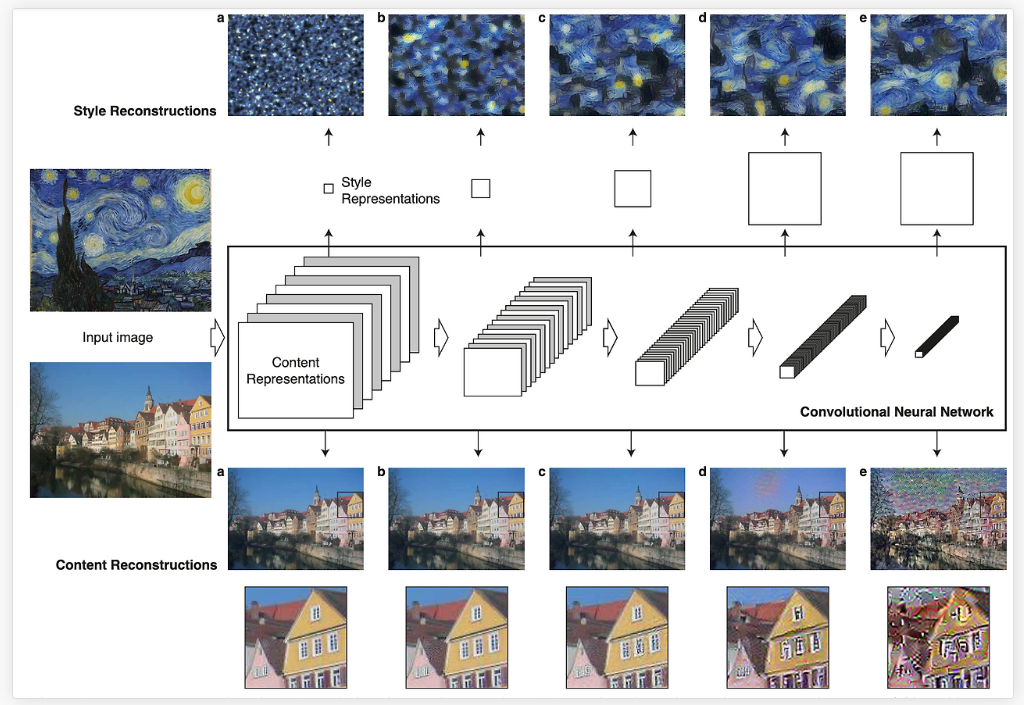

# [Neural Style Transfer 구현](https://deep-learning-study.tistory.com/680)

In [1]:
# 구글 드라이브 연결(데이터 로드를 위해서)
try:
    from google.colab import drive

    drive.mount('/content/data')
    root = "/content/data/MyDrive/google_lecture/06. deep learning/2. Vision Pytorch/data/style_transfer"
except:
    root = "./data/style_transfer"

Mounted at /content/data


In [2]:
# content와 style 이미지 불러오기
from PIL import Image
path2content = root+'/Content/ancient_city.jpg'
path2style = root+'/Style/bamboo_forest.jpg'

content_img = Image.open(path2content)
style_img = Image.open(path2style)

In [3]:
content_img

Output hidden; open in https://colab.research.google.com to view.

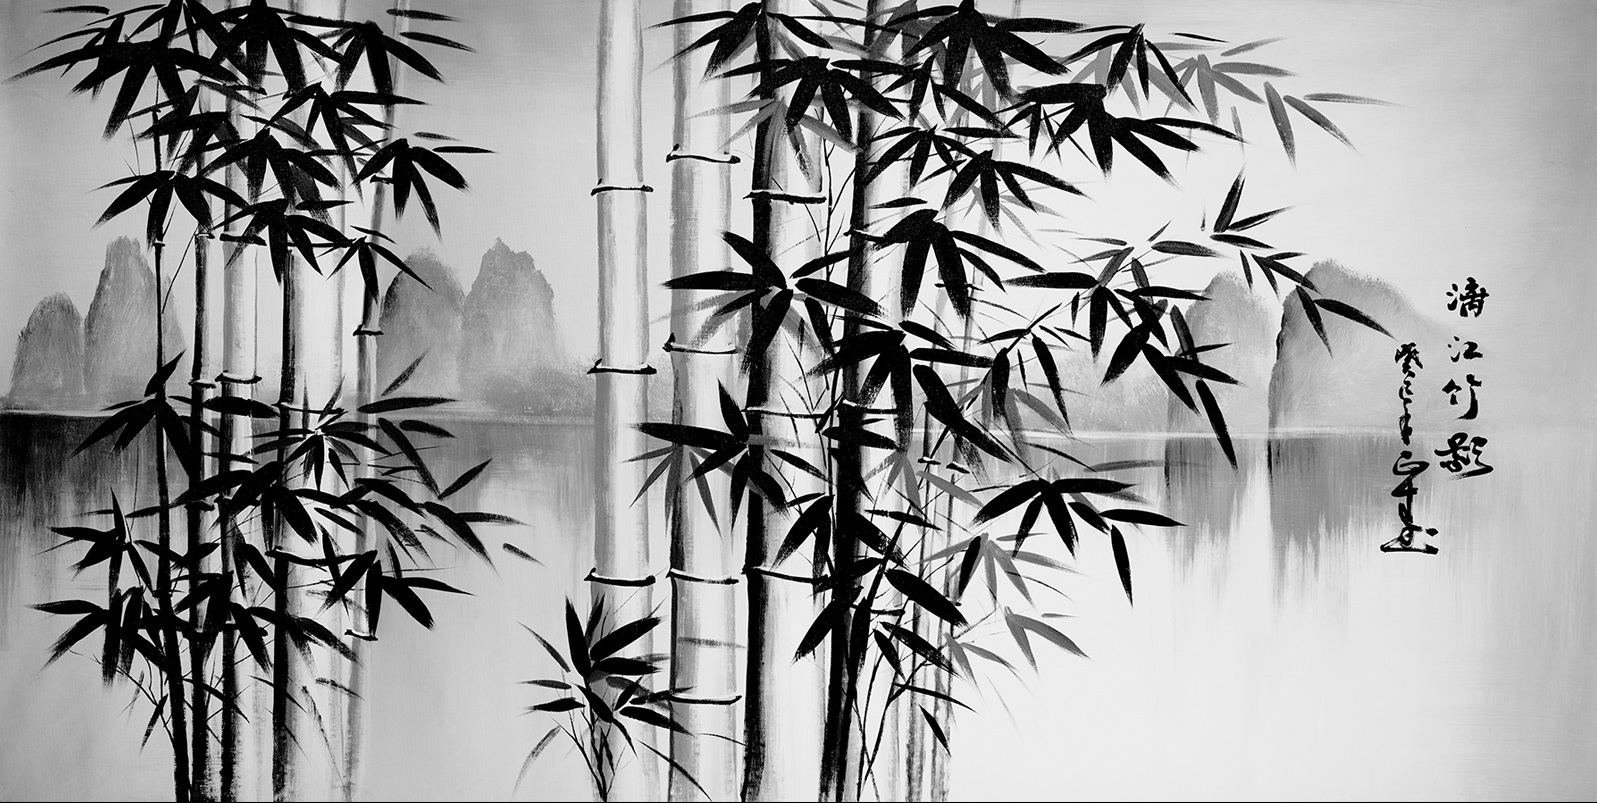

In [4]:
style_img

## transformation 적용하기
- resize, normalize를 적용하겠습니다.

In [5]:
import torchvision.transforms as transforms

h, w = 256, 384
mean_rgb = (0.485, 0.456, 0.406)
std_rgb = (0.229, 0.224, 0.225)

transformer = transforms.Compose([
                transforms.Resize((h,w)),
                transforms.ToTensor(),
                transforms.Normalize(mean_rgb, std_rgb)
])

In [6]:
# 이미지에 transformation 적용하기
content_tensor = transformer(content_img)
style_tensor = transformer(style_img)
print(content_tensor.shape, content_tensor.requires_grad)
print(style_tensor.shape, style_tensor.requires_grad)

torch.Size([3, 256, 384]) False
torch.Size([3, 256, 384]) False


In [7]:
# transformation이 적용된 image 시각화하기
import torch
import matplotlib.pyplot as plt
%matplotlib inline
from torchvision.transforms.functional import to_pil_image

def imgtensor2pil(img_tensor):
    img_tensor_c = img_tensor.clone().detach()
    img_tensor_c *= torch.tensor(std_rgb).view(3, 1,1)
    img_tensor_c += torch.tensor(mean_rgb).view(3,1,1)
    img_tensor_c = img_tensor_c.clamp(0,1)
    img_pil = to_pil_image(img_tensor_c)
    return img_pil

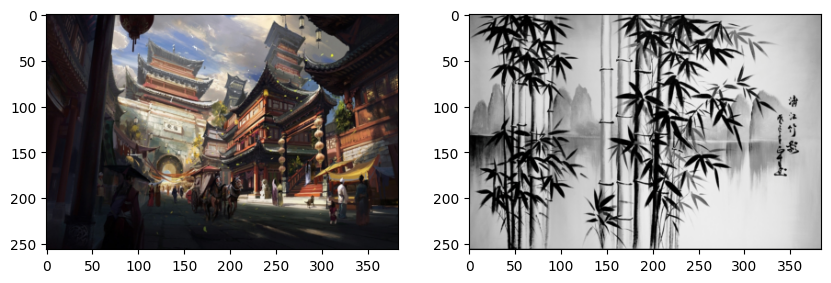

In [8]:
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(imgtensor2pil(content_tensor))
plt.subplot(1,2,2)
plt.imshow(imgtensor2pil(style_tensor))

## style transfer 구현하기
- pre-trained VGG19를 불러와서, content image와 style image의 특징을 추출합니다.

In [9]:
# pretrained VGG19를 불러옵니다
import torchvision.models as models

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_vgg = models.vgg19(pretrained=True).features.to(device).eval()

# 파라미터를 freeze 합니다.
for param in model_vgg.parameters():
    param.requires_grad_(False)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:06<00:00, 95.2MB/s]


## 손실함수 정의하기

In [10]:
# style loss와 content loss를 정의하기 위해
# 모델의 중간 feature를 얻은 후 Gram matrix를 계산해야 합니다.

# 모델의 중간 레이어의 출력값을 얻는 함수를 정의합니다.
def get_features(x, model, layers):
    features = {}
    for name, layer in enumerate(model.children()): # 0, conv
        x = layer(x)
        if str(name) in layers:
            features[layers[str(name)]] = x
    return features

-  gram matrix를 계산하는 함수입니다. style loss를 계산할 때 필요합니다.
- style loss는 input tensor와 style image의 gram matrix가 동일한 값을 갖는 방향으로 학습을 진행합니다.

In [11]:
# Gram matrix를 계산하는 함수를 정의합니다.
def gram_matrix(x):
    n, c, h, w = x.size()
    x = x.view(n*c, h*w)
    gram = torch.mm(x,x.t()) # 행렬간 곱셈 수행
    return gram

- content loss
  - content feature와 input feature 사이의 MSE를 계산합니다.

In [12]:
# content loss를 계산하는 함수를 정의합니다.
import torch.nn.functional as F

def get_content_loss(pred_features, target_features, layer):
    target = target_features[layer]
    pred = pred_features[layer]
    loss = F.mse_loss(pred, target)
    return loss

- style loss
  - input과 style의 gram matrix가 동일해지도록 학습합니다.

In [13]:
# style loss
def get_style_loss(pred_features, target_features, style_layers_dict):
    loss = 0
    for layer in style_layers_dict:
        pred_fea = pred_features[layer]
        pred_gram = gram_matrix(pred_fea)
        n, c, h, w = pred_fea.shape
        target_gram = gram_matrix(target_features[layer])
        layer_loss = style_layers_dict[layer] * F.mse_loss(pred_gram, target_gram)
        loss += layer_loss / (n*c*h*w)
    return loss

- pre-trained VGG19을 사용하여 content와 style image의 feature을 추출합니다.

In [14]:
# content와 style image를 위한 feature를 얻습니다.
feature_layers = {'0': 'conv1_1',
                  '5': 'conv2_1',
                  '10': 'conv3_1',
                  '19': 'conv4_1',
                  '21': 'conv4_2',
                  '28': 'conv5_1'}

con_tensor = content_tensor.unsqueeze(0).to(device)
sty_tensor = style_tensor.unsqueeze(0).to(device)

content_features = get_features(con_tensor, model_vgg, feature_layers)
style_features = get_features(sty_tensor, model_vgg, feature_layers)

- 추출한 특징을 확인합니다.

In [15]:
# content feature를 확인합니다.
for key in content_features.keys():
    print(content_features[key].shape)

torch.Size([1, 64, 256, 384])
torch.Size([1, 128, 128, 192])
torch.Size([1, 256, 64, 96])
torch.Size([1, 512, 32, 48])
torch.Size([1, 512, 32, 48])
torch.Size([1, 512, 16, 24])


## optimizer 정의하기
- input_tensor은 content image을 복사하여 생성합니다.
- optimizer은 input_tensor의 pixel value를 갱신합니다.
- 즉, 학습을 진행할수록 모델의 파라미터가 갱신되는 것이 아니라 input_tensor의 값이 갱신됩니다.

In [16]:
# content tensor을 복사한 input tensor을 생성합니다.
input_tensor = con_tensor.clone().requires_grad_(True)

# optimizer를 정의합니다.
from torch import optim
optimizer = optim.Adam([input_tensor], lr=0.01)

## 이미지 합성하기
- style_layers_dict는 5개의 conv layer에서 출력하는 style image의 특징들에 대한 가중치 정보를 갖고 있습니다.

In [17]:
# 하이퍼파라미터를 정의합니다
num_epochs = 300
content_weight = 1e1
style_weight = 1e4
content_layer = 'conv5_1'
style_layers_dict = {'conv1_1':0.75,
                     'conv2_1':0.5,
                     'conv3_1':0.25,
                     'conv4_1':0.25,
                     'conv5_1':0.25}

In [18]:
# style transfer
for epoch in range(num_epochs+1):
    optimizer.zero_grad()
    input_features = get_features(input_tensor, model_vgg, feature_layers) # feature_layers에 해당하는 layer의 출력값 얻기
    content_loss = get_content_loss(input_features, content_features, content_layer) #
    style_loss = get_style_loss(input_features, style_features, style_layers_dict)
    neural_loss = content_weight * content_loss + style_weight * style_loss
    neural_loss.backward(retain_graph=True)
    optimizer.step()
    if epoch % 100 == 0:
        print('epoch {}, content loss: {:.2}, style loss: {:.2}'.format(epoch, content_loss, style_loss))

epoch 0, content loss: 0.0, style loss: 5.8e+02
epoch 100, content loss: 5.9, style loss: 6.7e+01
epoch 200, content loss: 6.8, style loss: 2.8e+01
epoch 300, content loss: 7.4, style loss: 1.8e+01


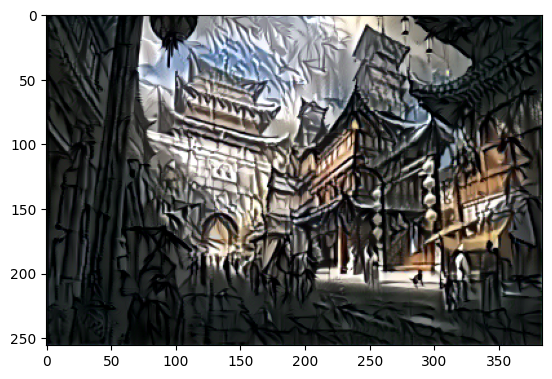

In [19]:
# 결과 시각화
plt.imshow(imgtensor2pil(input_tensor[0].cpu()))